<a href="https://colab.research.google.com/github/Edward-TL/amazon_scraper/blob/master/Amazon_Mx_Music_Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [21]:
#For the system
import os

#Manage of time
from datetime import datetime, timedelta
from pytz import timezone
import time
import re

#Manage of files
import pandas as pd
import csv

#Graph tools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.patches as mpatches

#interactive visualization

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

plt.show = plt.gcf

In [22]:
%cd 'drive/My Drive/Colab Notebooks/4SS/4SS_db/testing/Masters/mx/parquet'
!ls

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/4SS/4SS_db/testing/Masters/mx/parquet'
/content/drive/My Drive/Colab Notebooks/4SS/4SS_db/testing/Masters/mx/parquet
mx-master_db_amazon-devices.parquet  mx-master_db_kitchen.parquet
mx-master_db_automotive.parquet      mx-master_db_musical-instruments.parquet
mx-master_db_baby.parquet	     mx-master_db_music.parquet
mx-master_db_books.parquet	     mx-master_db_officeproduct.parquet
mx-master_db_digital-text.parquet    mx-master_db_pet-supplies.parquet
mx-master_db_dvd.parquet	     mx-master_db_shoes.parquet
mx-master_db_electronics.parquet     mx-master_db_software.parquet
mx-master_db_grocery.parquet	     mx-master_db_sports.parquet
mx-master_db_handmade.parquet	     mx-master_db_tools.parquet
mx-master_db_hpc.parquet	     mx-master_db_toys.parquet
mx-master_db_industrial.parquet      mx-master_db_videogames.parquet


In [23]:
df = pd.read_parquet('mx-master_db_music.parquet')

# Tools

## Count if

In [24]:
def count_if(array, value):
    count = 0
    for element in array:
        if element == value:
            count += 1
    return count

## array count

In [25]:
def array_count(elements_to_count, original_array):
    count_array = [None] * len(elements_to_count)
    c = 0

    for value in range(len(elements_to_count)):
        count_array[c] = original_array.count(elements_to_count[value])
        c += 1
        
    return count_array

## rank set list

In [26]:
def rank_set_list(df, rank, info, set_list=True, array=True):
    ranking = df[df['Rank'] == rank]
    raw_info_in_rank = ranking[info].to_list()

    if set_list == True:
        set_info = list(set(raw_info_in_rank))
        none_cases = count_if(set_info, None)
        if none_cases > 0:
            set_info.remove(None)

        if array == True:
            return set_info, raw_info_in_rank

        else: return set_info
    
    else: return raw_info_in_rank

    

In [27]:
def rank_info(df, rank, column_info, info_name='Albums'):
    set_info, raw_info_in_rank = rank_set_list(df, rank, column_info)
    info_count = array_count(elements_to_count=set_info, original_array=raw_info_in_rank)
    info = {info_name: set_info,
            'Counts' : info_count}
    df_info = pd.DataFrame(info)
    df_info = df_info.sort_values(by=['Counts'])

    return df_info

In [28]:
def plot_rank_barh(x, y, rank):
    plt.figure(figsize=(8,8))
    plt.barh(y=y, width=x)

    for i, v in enumerate(x):
        plt.text(v+1, i, str(v), fontweight='bold')

    xlabel = f'Times shown at #{rank} position' 
    plt.xlabel(xlabel)

    header = f'Times an album hit the #{rank} position' 
    plt.title(label=header)

    plt.show()

In [29]:
def barh_and_scatters(pivot_column, df_info=df, top_rank=5, extracted_info_name='Albums', n_plots=1):

    top = top_rank + 1 
    info = pivot_column
    df = df_info

    for rank in range(1, top):
        
        #Extract Info
        
        extracted_df = rank_info(df, rank, info, extracted_info_name)
        albums = extracted_df[extracted_info_name].to_list()
        info_count = extracted_df['Counts'].to_list()

        #Plot
        plot_rank_barh(info_count, albums, rank)

        # scatter
        rank_df = df[df['Rank'] == rank]
        x = rank_df['Stars']
        y = rank_df['Reviews']
        
        groups = rank_df.groupby(info)        
        markers = ['o', 'x', 'v', 'p']
        fig, ax = plt.subplots()
        m = 0
        p = 0
        

        for name, group in groups:
            if (m % 10 == 0) and (m > 0):
                p += 1

            ax.plot(group.Stars , group.Reviews, marker=markers[p], linestyle='', label=name)
            m += 1

        plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)

In [30]:
def barh_plus_scatter(pivot_column, df_info=df, top_rank=5, extracted_info_name='Albums', n_plots=1, w_fig=8, h_fig=8):
    top = top_rank + 1 
    info = pivot_column
    df = df_info

    for rank in range(1, top):
        
        #Extract Info
        
        extracted_df = rank_info(df, rank, info, extracted_info_name)
        albums = extracted_df[extracted_info_name].to_list()
        info_count = extracted_df['Counts'].to_list()

        #Plot
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(w_fig, h_fig))
        title = f' Top #{rank} Info' 
        fig.suptitle(title)
        # plt.figure(figsize=(w_fig,h_fig))

        ax1.barh(y=albums, width=info_count)

        for i, v in enumerate(info_count):
            ax1.text(v+1, i, str(v))

        xlabel = f'Times shown at #{rank} position' 
        ax1.set_xlabel(xlabel)

        bar_header = f'Times an {extracted_info_name} hit the #{rank} position' 
        ax1.set_title(label=bar_header)

        # scatter
        rank_df = df[df['Rank'] == rank]
        x = rank_df['Stars']
        y = rank_df['Reviews']
        
        ax2.set_xlabel('Stars')
        ax2.set_title(f'Reviews vs Stars per {extracted_info_name} at the #{rank} position')
        ax2.set_ylabel('Reviews')
        groups = rank_df.groupby(info)        
        markers = ['o', 'x', 'v', 'p']
        
        m = 0
        p = 0
        for name, group in groups:
            if (m % 10 == 0) and (m > 0):
                p += 1
            ax2.plot(group.Stars , group.Reviews, marker=markers[p], linestyle='', label=name)
            
            m += 1

        ax2.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)
        plt.show()
        

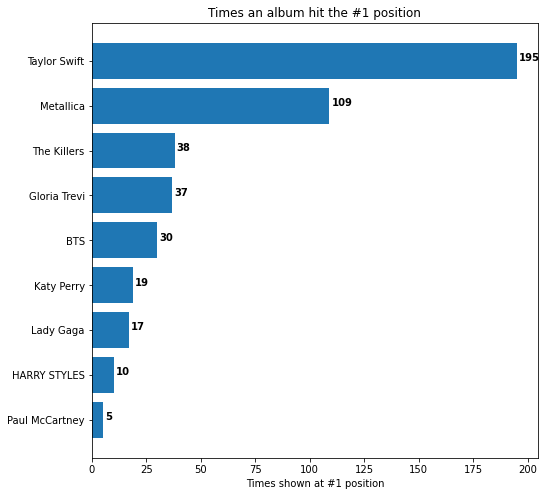

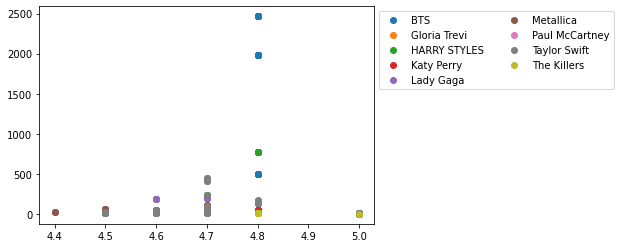

In [31]:
artist = 'Authors/Company'
barh_and_scatters(artist, top_rank=1)


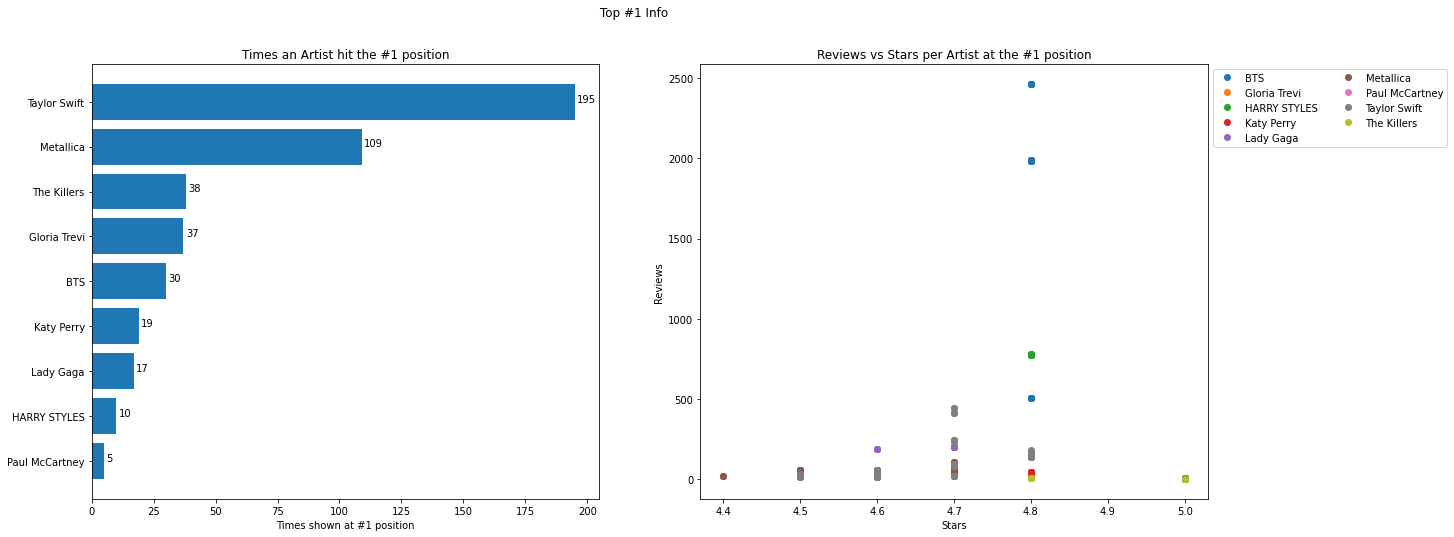

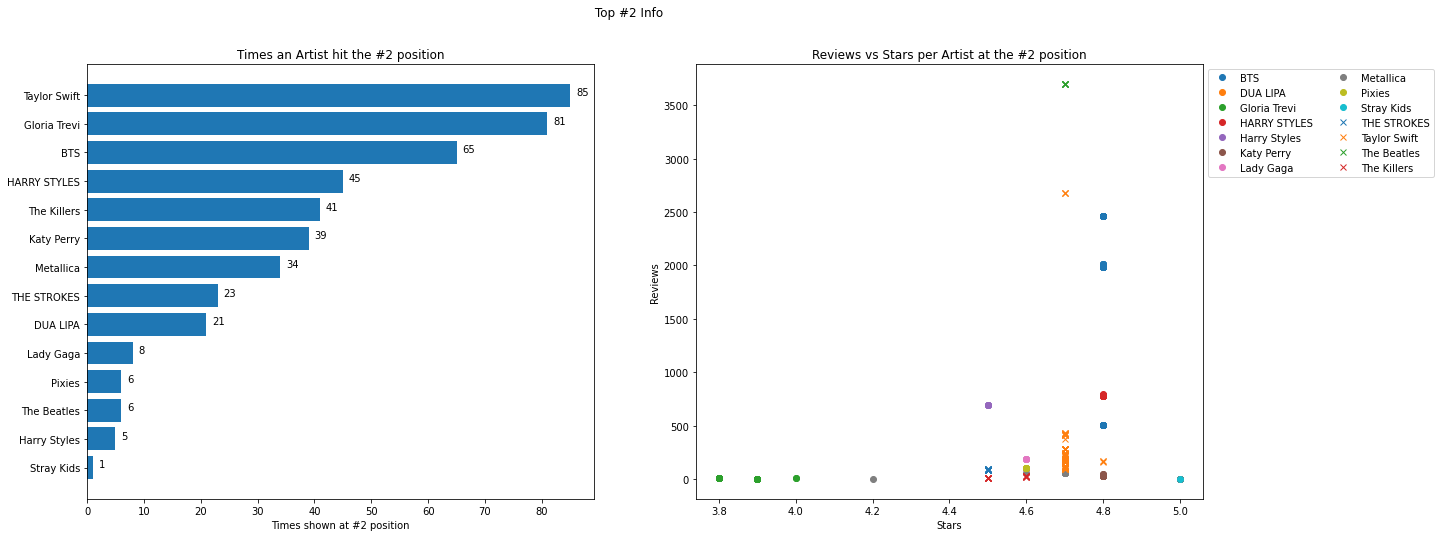

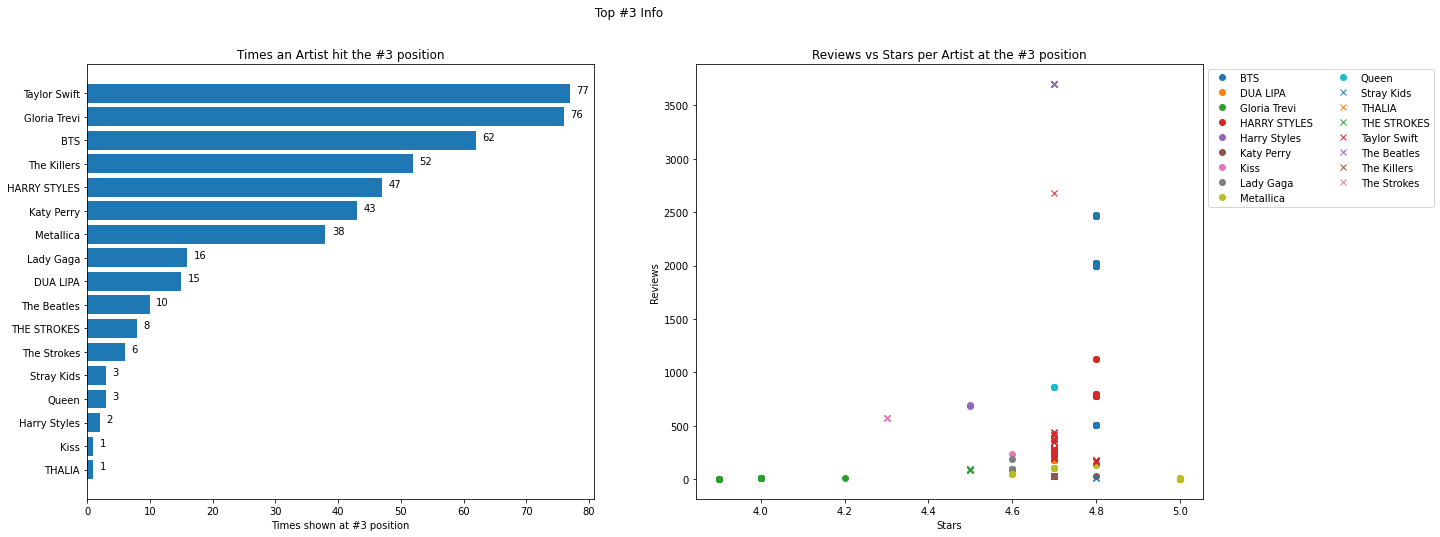

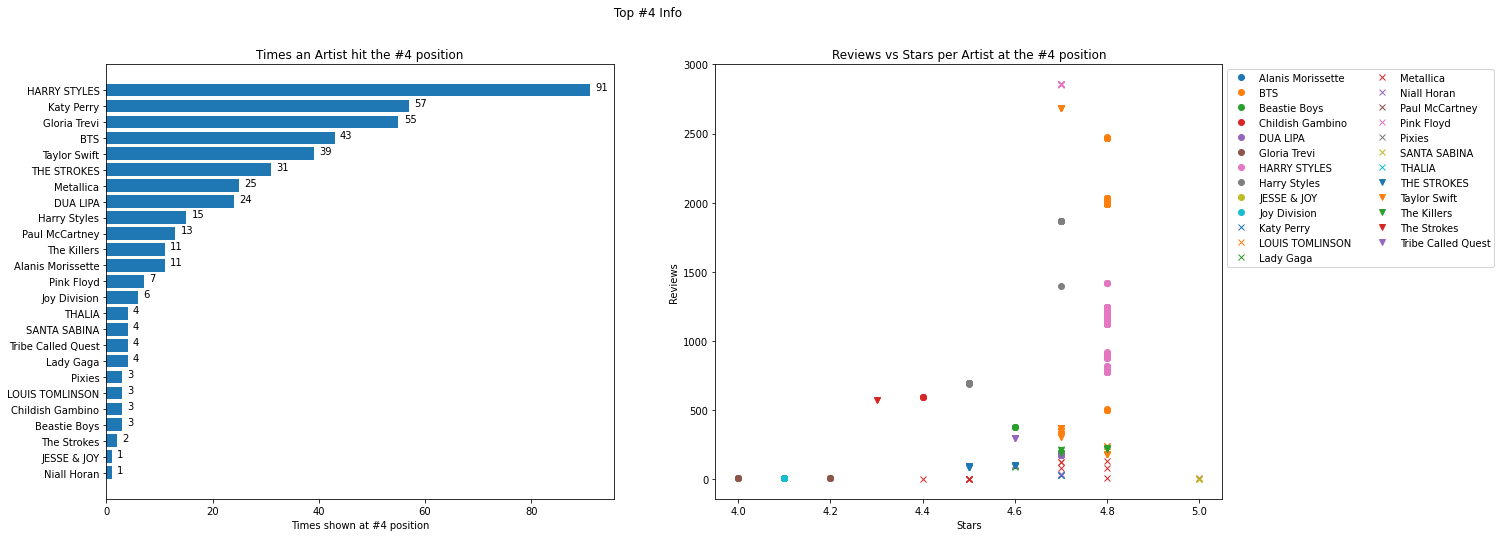

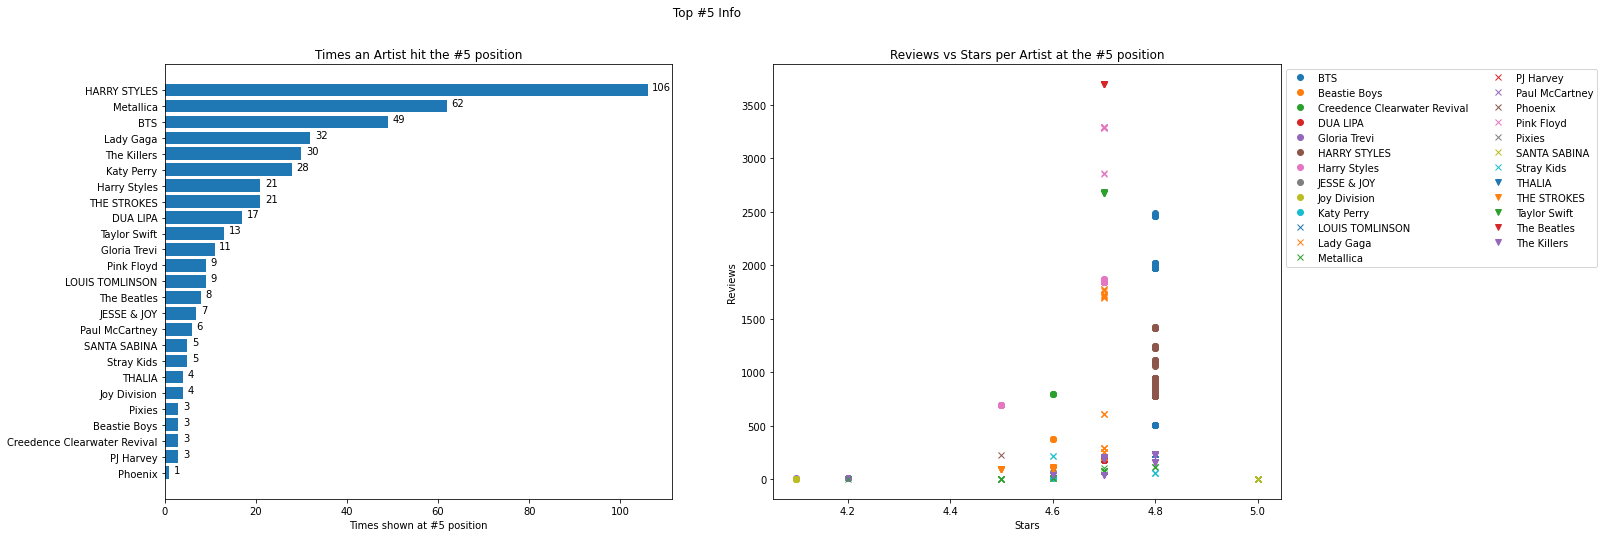

In [32]:
barh_plus_scatter(artist, extracted_info_name='Artist' , top_rank=5, w_fig=20, h_fig=8)

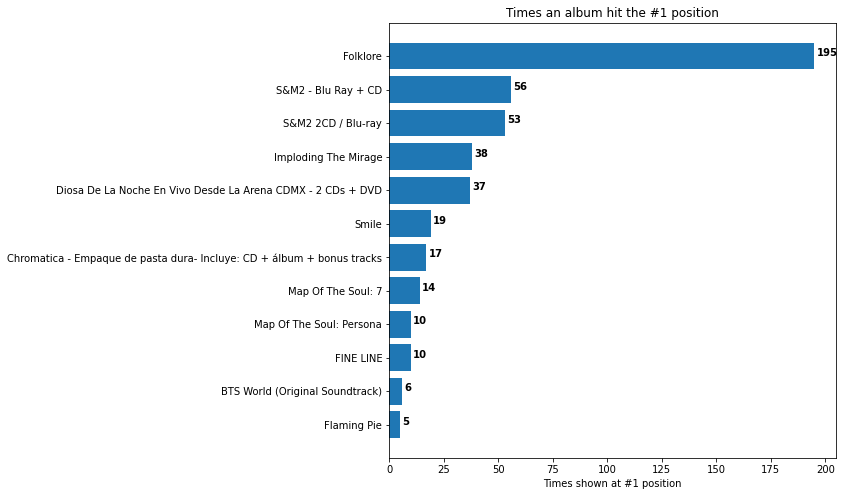

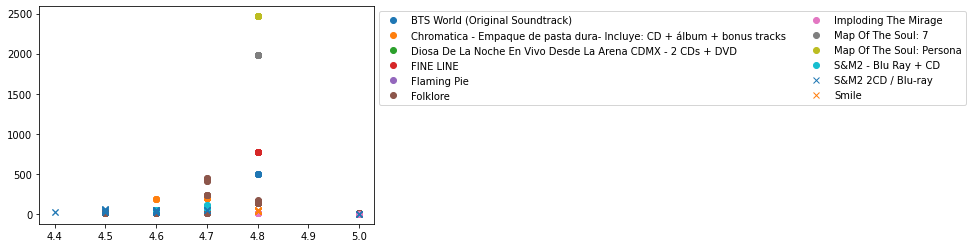

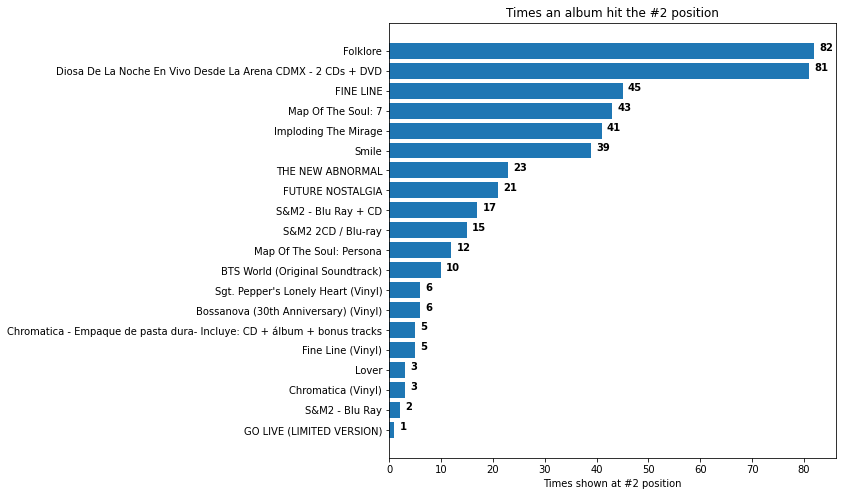

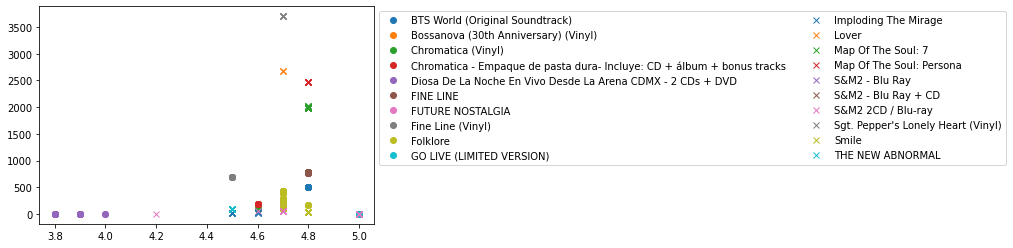

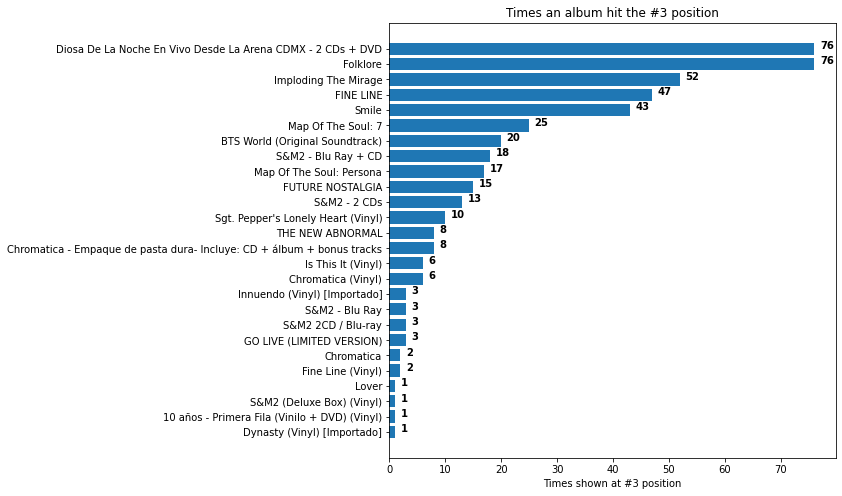

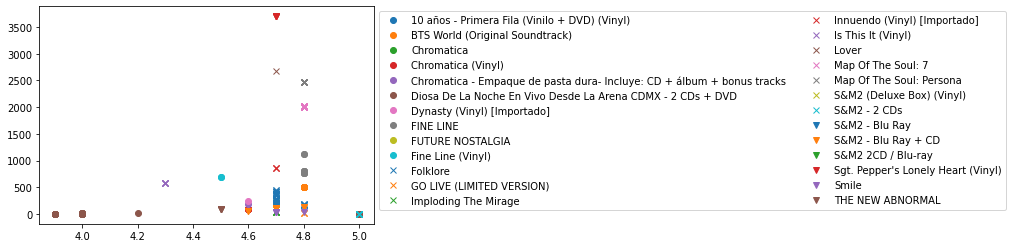

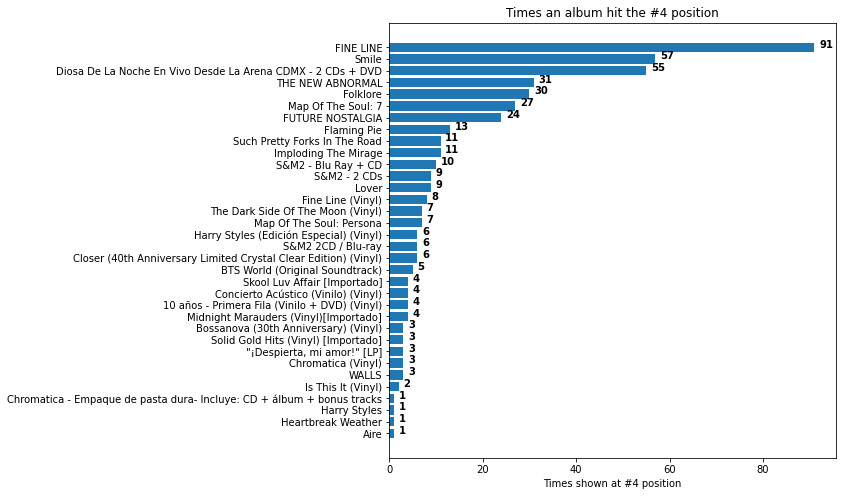

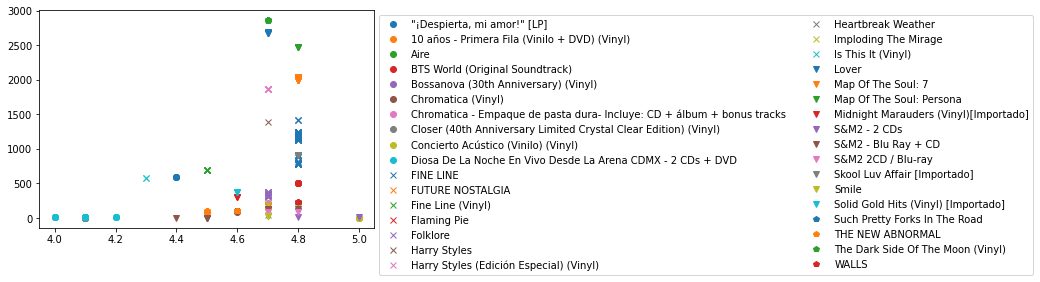

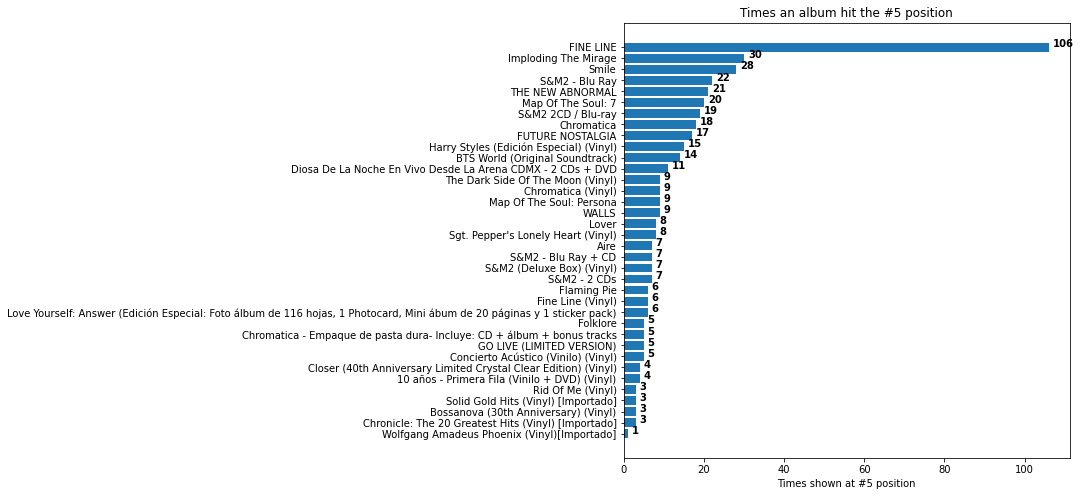

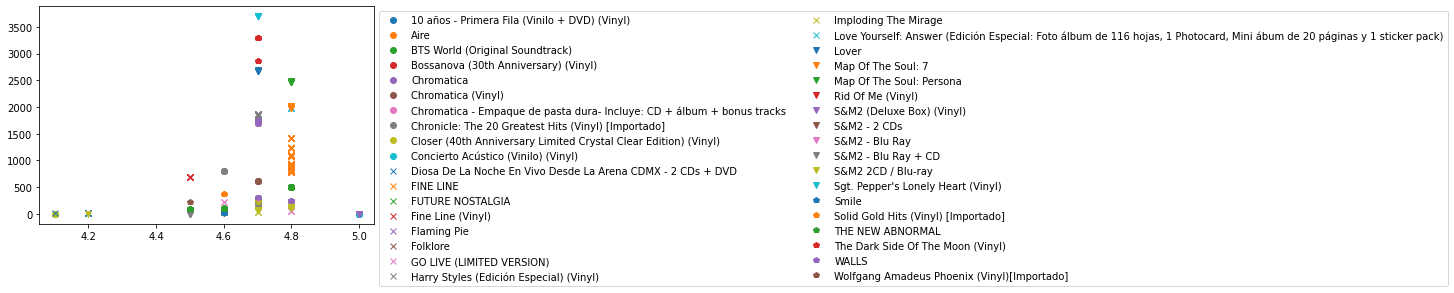

In [33]:
album = 'Product Names'
barh_and_scatters(album)

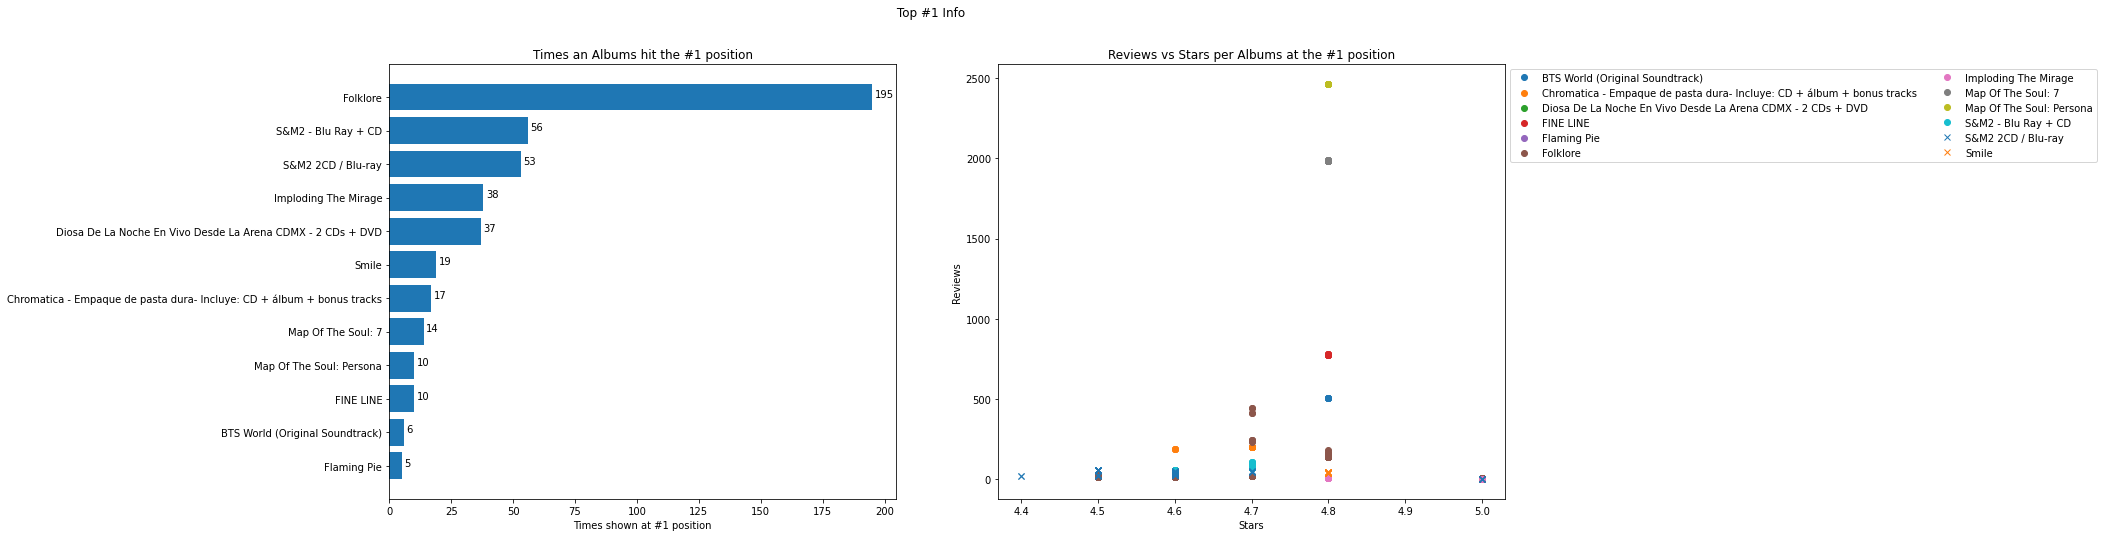

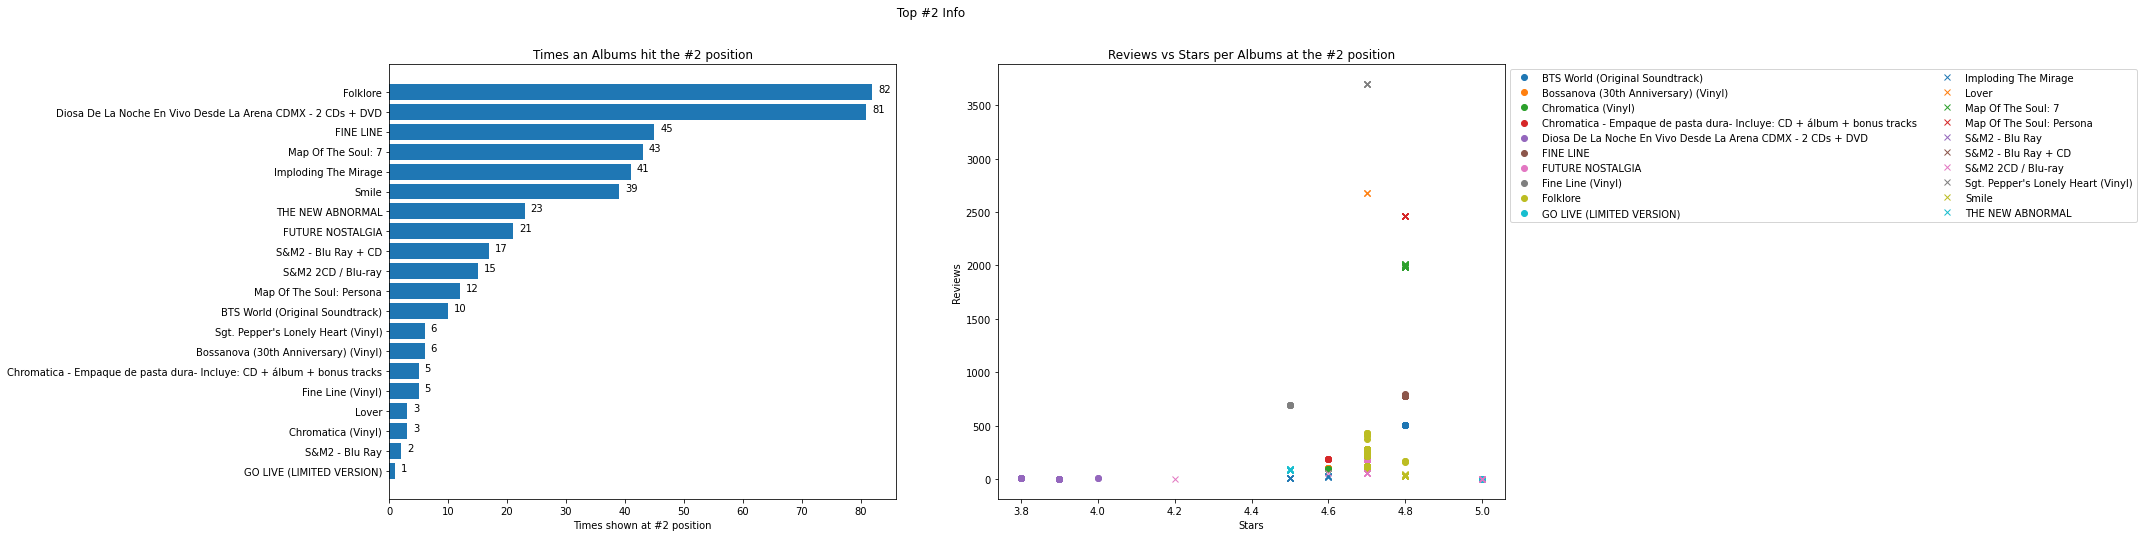

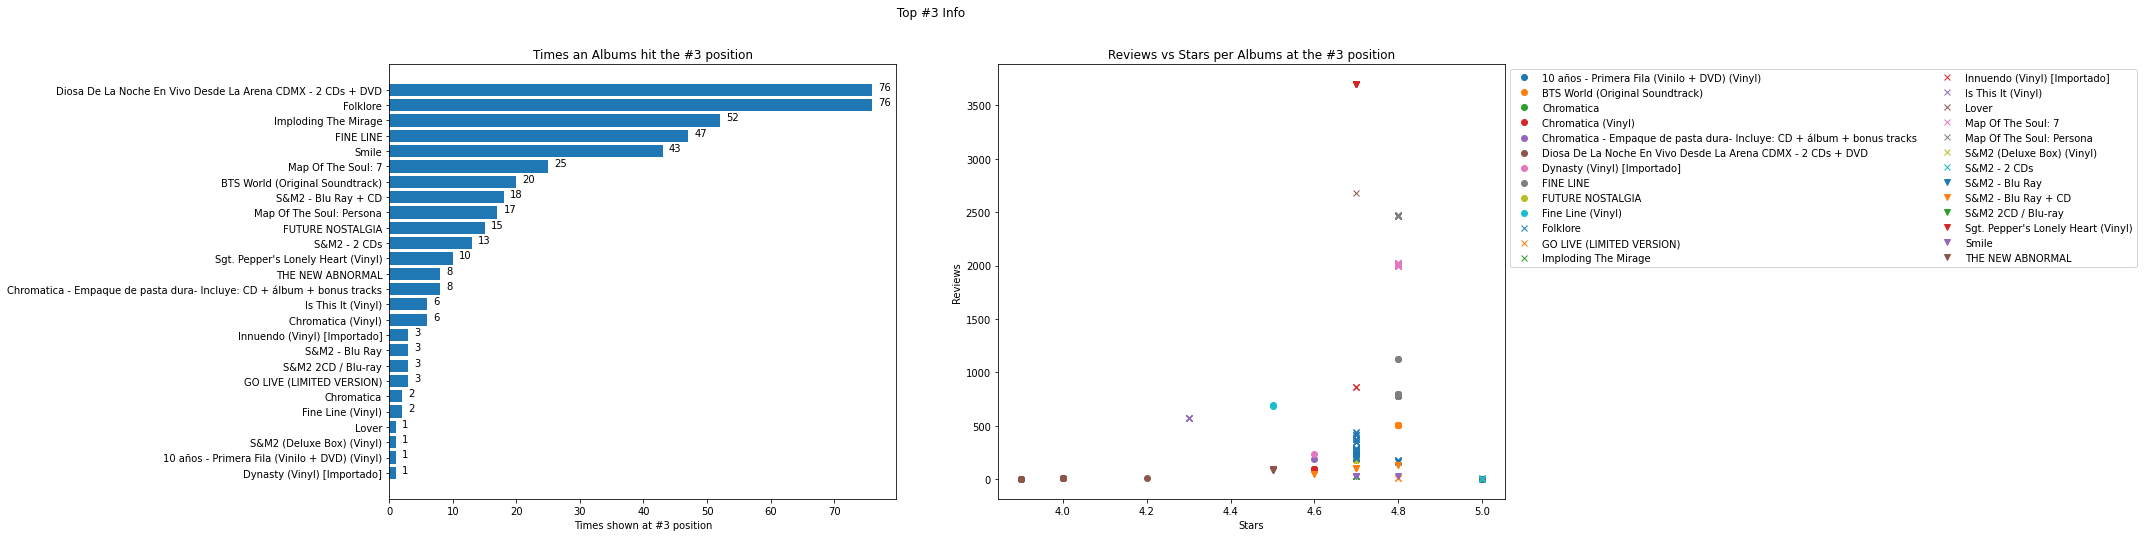

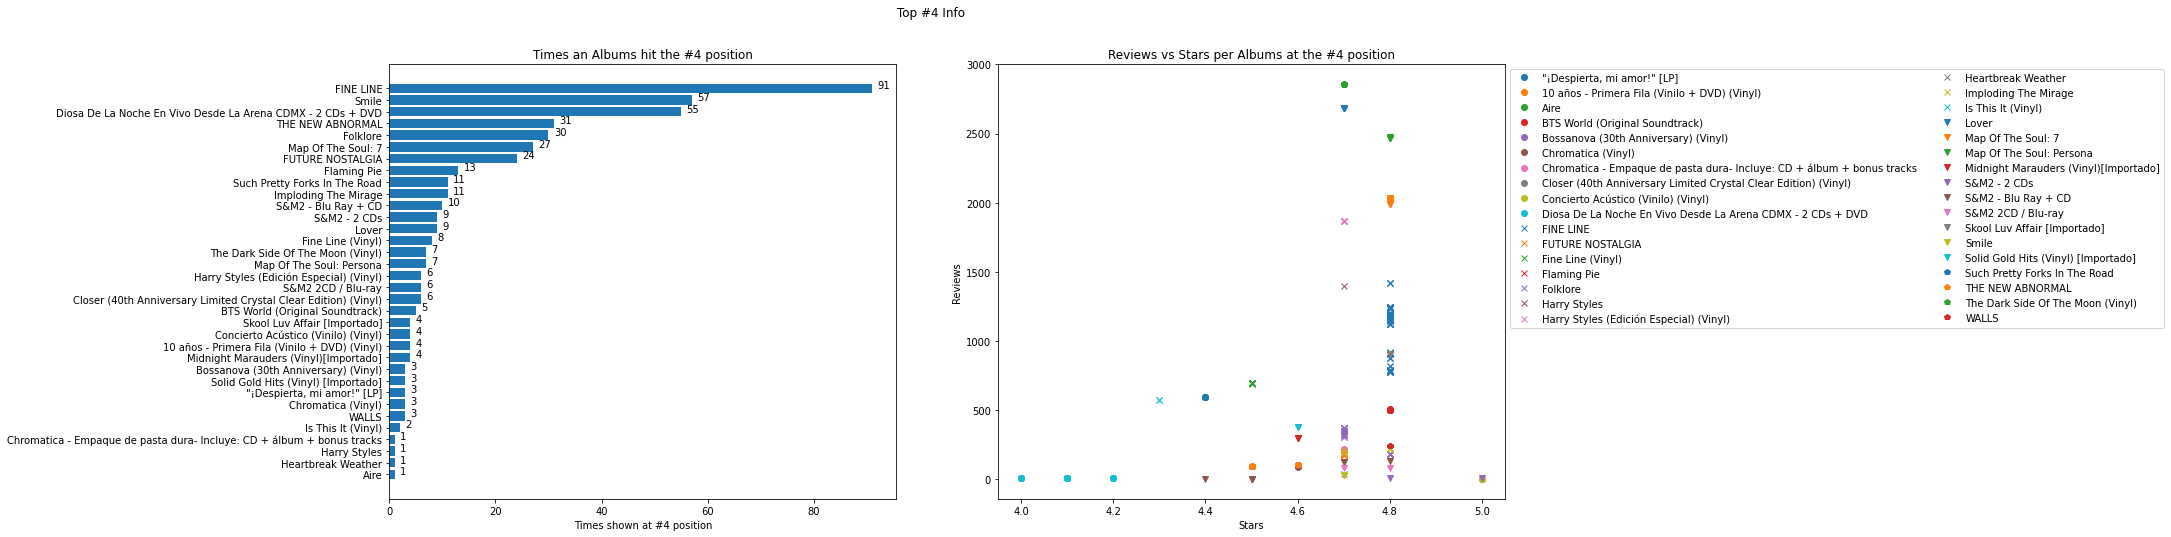

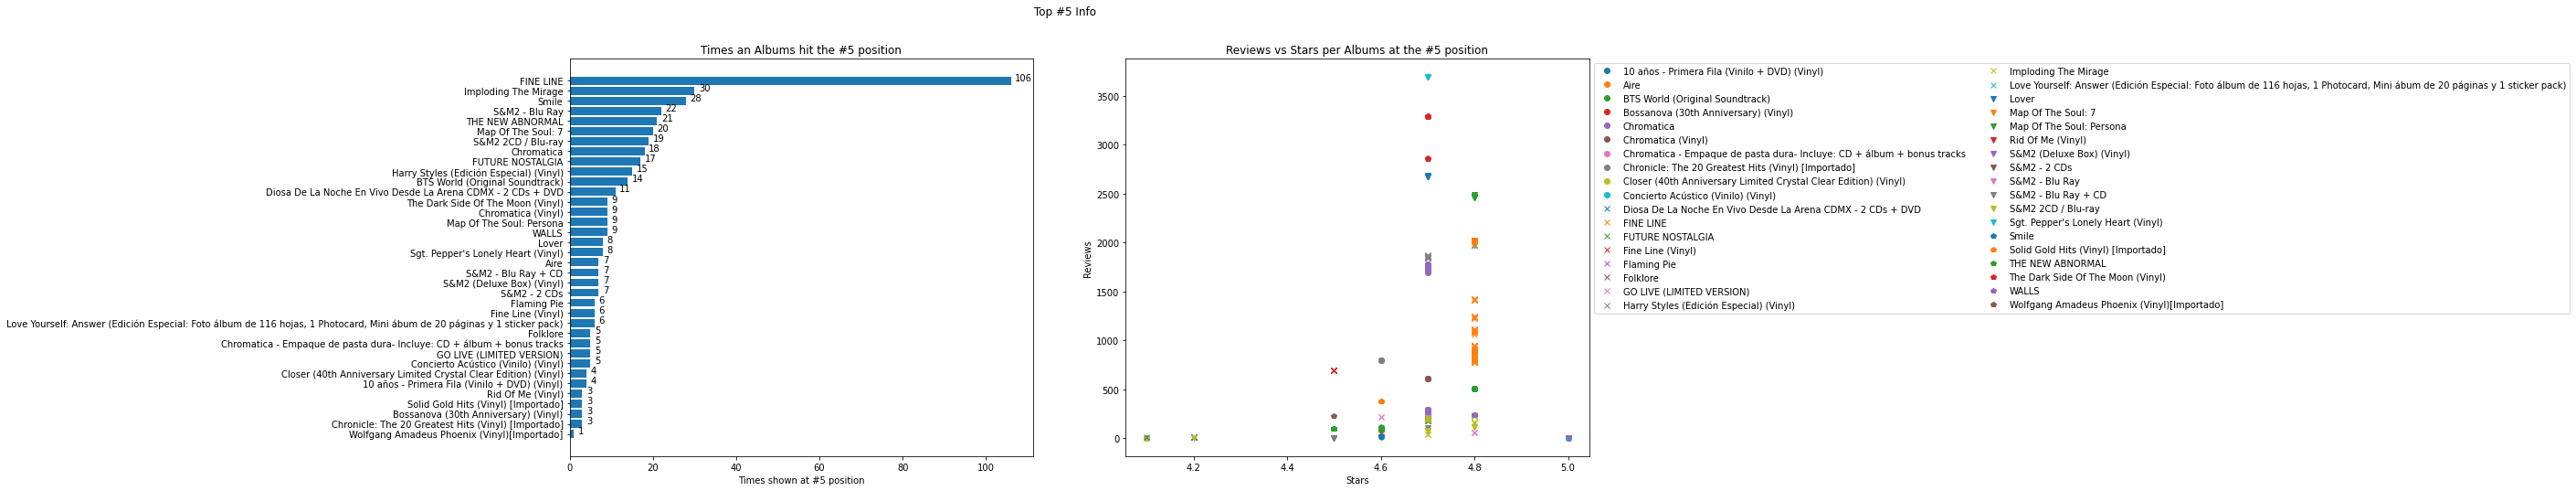

In [34]:
barh_plus_scatter(album, top_rank=5, w_fig=20, h_fig=8)

# Plots

In [35]:
df.columns

Index(['time', 'Rank', 'Product Names', 'Product ID', 'Image ID', 'Stars',
       'Reviews', 'Authors/Company', 'Edition/Console', 'Price_std_or_min',
       'Max_prices'],
      dtype='object')

In [40]:
def interactive_bar_scatter(pivot_column, df_info=df, top_rank=5, extracted_info_name='Albums', n_plots=1, w_fig=8, h_fig=8):
    top = top_rank + 1 
    info = pivot_column
    df = df_info

    for rank in range(1, top):
        
        #Extract Info
        
        extracted_df = rank_info(df, rank, info, extracted_info_name)
        albums = extracted_df[extracted_info_name].to_list()
        info_count = extracted_df['Counts'].to_list()

        bar_header = f'Times an album hit the top #{rank}'
        box_header = f'Stats of of the #{rank} position'
        scatter_header = f'Reviews vs Stars of the #{rank} position'
        
        fig = make_subplots(
            rows=1, cols=2,
            specs=[[{'type': 'bar'}, None]],
            subplot_titles=(bar_header, None)
            )

        #Horizontal Bars
        fig.add_trace(
            go.Bar(
                x = info_count, y =albums , name = bar_header, orientation = 'h',
                showlegend = False,
                text = albums,
                    hovertemplate=
                    "<b>%{text}</b><br><br>" +
                    "Stars: %{x}<br>" +
                    "Reviews: %{y:,0f}<br>"
                ), row = 1, col = 1)
        
        fig.update_yaxes(title_text=extracted_info_name, row=1, col=1)
        fig.update_layout(
            title = f'Top #{rank} Info',
            margin = dict(r=10, t=50, b=0, l=10),
            height = 400,
        )
        fig.show()


        #FIGURE 2
        fig2 = make_subplots(
            rows=1, cols=5,
            column_widths=[0.19, 0.19, 0.19, 0.005, 0.425],
            specs=[[{'type': 'box'}, {'type': 'box'}, {'type': 'box'}, None, {'type': 'scatter'}]],
            subplot_titles=(None, None, None, None, scatter_header)
        )

        #General Info
        top_5 = df[(df['Rank'] >= 1) & (df['Rank']<=5)]
        rank_df = df[df['Rank'] == rank]
        box_info = ['Stars', 'Reviews', 'Price_std_or_min']
        colors = ['gold', 'yellow', 'crimson', 'red','green','lightseagreen']

        #Box
        b = 1
        c = 0
        for i in box_info:
            fig2.add_trace(
                go.Box(
                    y = top_5[i], showlegend = False,
                    name = f'Tops 1-5',
                    marker_color = colors[c],
                ), row = 1, col = b)
            
            c += 1

            fig2.add_trace(
                go.Box(
                    y = rank_df[i], showlegend = False,
                    name = f'Top {rank}',
                    marker_color = colors[c],
                ),
                row = 1, col = b)
            if i == 'Price_std_or_min':
                i = 'Price'
            fig2.update_xaxes(title_text=i, row=1, col=b)
            b += 1
            c += 1 

        #Scatter
        groups = rank_df.groupby(info) 
        for name, group in groups:
            fig2.add_trace(
                go.Scatter(
                    x = group.Stars, y = group.Reviews, mode = 'markers', name = name,
                    text = group[artist],
                    hovertemplate=
                    "<b>%{text}</b><br><br>" +
                    "Stars: %{x}<br>" +
                    "Reviews: %{y:,0f}<br>"
                    ), row = 1, col = 5)
            
        fig2.update_yaxes(title_text="Reviews", row=1, col=5)
        fig2.update_xaxes(title_text="Stars", row=1, col=5)
        fig2.update_layout(
            margin=dict(r=10, t=20, b=50, l=10),
            height=300,
        )
        
        fig2.show()


In [41]:
interactive_bar_scatter(artist, top_rank=5, extracted_info_name="Artist/Band")

In [44]:
rank = 1
rank_df =  df[df['Rank'] >= rank]
#Rank Lines

go.Scatter(x = rank_df.time, y= rank_df['time']
)

Scatter({
    'x': array(['2020-07-31 00:38', '2020-07-31 00:38', '2020-07-31 00:38', ...,
                '2020-09-08 19:15', '2020-09-08 19:15', '2020-09-08 19:15'],
               dtype=object),
    'y': array(['2020-07-31 00:38', '2020-07-31 00:38', '2020-07-31 00:38', ...,
                '2020-09-08 19:15', '2020-09-08 19:15', '2020-09-08 19:15'],
               dtype=object)
})

In [ ]:
top_5 = df[(df['Rank'] >= 1) & (df['Rank']<=5)]
groups = top_5.groupby('Rank')
# Plot
fig, ax = plt.subplots()

p = 0
markers = ['D', 'P', 'v', 'x', '.']

for name, group in groups:
    ax.plot(group.Stars , group.Reviews, marker=markers[p], linestyle='', label=name)
    p += 1

plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)

In [ ]:
group = df[df['Rank'] == 1]
group.columns

In [ ]:
top_5 = df[(df['Rank'] >= 1) & (df['Rank']<=5)]
groups = top_5.groupby('Rank')
# Plot
fig = go.Figure()
s = 20

m = 0
markers = ['x','diamond','circle','square','star']
for rank in range(5, 0, -1):
    group = df[df['Rank'] == rank]
    fig.add_trace(
        go.Scatter(
            x = group.Stars,
            y = group.Reviews,
            name = f'Top #{int(rank)}',
            mode = 'markers',
            marker = dict(size=s),
            marker_symbol = markers[m],
            text = group[artist],
            hovertemplate=
            "<b>%{text}</b><br><br>" +
            "Stars: %{x}<br>" +
            "Reviews: %{y:,0f}<br>"
        )
    )    

    s -= 3
    m += 1

fig.update_layout(
    title = f'Stars and Reviews of Top 5 positions',
) 

fig.update_layout(
    xaxis={'title' : 'Stars'},
    yaxis={'title' : 'Reviews'}
)


fig.show()

In [ ]:
best_seller = df[df[album] == 'Folklore']
best_seller.columns

In [ ]:
x_values = best_seller['time'].dropna()
y_values = best_seller['Rank'].dropna()

date_format = mdates.DateFormatter('%d')
plt.xlabel('August Days')




# ax = plt.gca()

# # formatter = mdates.DateFormatter("%d-%m")
# # ax.xaxis.set_major_formatter(formatter)


plt.plot(x_values, y_values)
